In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


In [2]:
!pip install ftfy
!pip install emoji
!pip install -U deep-translator
!pip install nltk
!pip install transformers
!pip install sentencepiece
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl size=187456 sha256=cc0807ca0ad73574f064e9053d1f29ff6606de560b10bf2836a20d7f842496fd
  Stored in directory: /root/.cache/pip/wheels/88/6a/a6/a1283cc145323a1fb3d475bd158ee60b248ab1985230d266fc
Successfully built editdistpy


In [3]:
import pandas
import matplotlib.pyplot
import seaborn
from deep_translator import GoogleTranslator
import emoji
import ftfy
from itertools import cycle
import nltk
from nltk.corpus import stopwords
import re
import numpy
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc
    )
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from symspellpy.symspellpy import SymSpell, Verbosity
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification
    )
from tqdm import tqdm
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nltk.download('stopwords')
nltk.download('punkt')
pandas.set_option('display.max_colwidth', None)
pandas.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 1. Análisis descriptivo de los datos

En primer lugar realizaremos un análisis exploratorio de datos para comprender qué acciones debemos llevar a cabo antes de utilizarlos en nuestro modelo. En concreto, nos centraremos en la calidad de los datos y la presencia de datos faltantes, la distribución de las clases, y la longitud de las frases.

In [4]:
df_train = pandas.read_csv('train.csv')
df_test = pandas.read_csv('test.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       11000 non-null  object
 1   text     11000 non-null  object
 2   label    11000 non-null  int64 
 3   origin   11000 non-null  object
 4   id-type  11000 non-null  object
 5   english  9960 non-null   object
 6   french   9959 non-null   object
dtypes: int64(1), object(6)
memory usage: 601.7+ KB


In [6]:
print(df_train['label'].unique())
print(df_train['origin'].unique())
print(df_train['id-type'].unique())

[0 1]
['news-articles' 'twitter']
['url' 'twitterId']


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       5000 non-null   object
 1   text     5000 non-null   object
 2   label    5000 non-null   int64 
 3   origin   5000 non-null   object
 4   id-type  5000 non-null   object
 5   english  4987 non-null   object
 6   french   4990 non-null   object
dtypes: int64(1), object(6)
memory usage: 273.6+ KB


In [8]:
print(df_test['label'].unique())
print(df_test['origin'].unique())
print(df_test['id-type'].unique())

[0 1]
['news-articles' 'twitter']
['url' 'twitterId']


Esta descripción básica de la estructura de los datasets ya nos ofrece bastante información acerca de los datos. En concreto, observamos que hay un pequeño porcentaje de datos nulos en las columnas que contienen las traducciones.

In [9]:
df_train.head()

,id,text,label,origin,id-type,english,french
0,https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102,"Durante su intervenciÃ³n, el vicesecretario de Vox tambiÃ©n ha dejado patente la crisis a la que se enfrenta la derecha despuÃ©s de que Ciudadanos apoyase la pasada prÃ³rroga del estado de alarma, como se espera que tambiÃ©n apoye la que se debate maÃ±ana.",0,news-articles,url,"Espinosa de los Monteros has compared both protests to the funeral of the former leader of IU and former mayor of Córdoba, Julio Anguita, who passed away on May 16th due to a cardiac arrest.","Espinosa de los Monteros a comparé les deux manifestations avec les funérailles de l'ancien dirigeant d'IU et ancien maire de Cordoue, Julio Anguita, décédé le 16 mai dernier d'un arrêt cardiaque."
1,1.271010900259078e+18,"Nueva manipulaciÃ³n a la mujer de la @rfef, dÃ³nde se quedÃ³ la igualdad ante la Ley del art 14 de la ConstituciÃ³n @VOX_Congreso seguirÃ¡ luchando. https://t.co/qopoFRbqyQ",1,twitter,twitterId,"New manipulation of the woman from @rfef, where is the equality before the Law of article 14 of the Constitution @VOX_Congreso will continue fighting. https://t.co/qopoFRbqyQ","Nouvelle manipulation de la femme de la @rfef, où est passée l'égalité devant la loi de l'article 14 de la Constitution @VOX_Congreso continuera à se battre. https://t.co/qopoFRbqyQ"
2,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Acciona que se enfrentan a un ERE.\n\nâï¸El gobierno mÃ¡s preocupado de sus polÃ­ticas progres que de crear un tejido industrial fuerte.\n\nâï¸Los sindicatos cÃ³mplices preocupados por agradar al gobierno.\n\nhttps://t.co/CqJnPAKzfx,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing a redundancy plan.\n\nâï¸The government more concerned about its progressive policies than creating a strong industrial fabric.\n\nâï¸The complicit unions worried about pleasing the government.\n\nhttps://t.co/CqJnPAKzfx,SOLIDARITÉ avec les 500 travailleurs d'Acciona qui font face à un ERE.\n\nâï¸Le gouvernement plus préoccupé par ses politiques progressistes que par la création d'un tissu industriel solide.\n\nâï¸Les syndicats complices préoccupés par plaire au gouvernement.\n\nhttps://t.co/CqJnPAKzfx
3,1.2811132626507776e+18,"âï¸ #BuenosDÃ­as #FelizJueves \n\n MaÃ±ana nuestra candidata a la Xunta @Beatriz_Pino_ , estarÃ¡ acompaÃ±ada de @Tonicanto1 y @GuillermoDiazCs en #SantiagodeCompostela #StopNacionalismo \n\n Alameda \n\nâ° 12:30h\n\n Â¡Te esperamos!\n#MoitoQueGaÃ±ar https://t.co/fbpFEv9aiu",0,twitter,twitterId,"âï¸ #GoodMorning #HappyThursday\n\nTomorrow our candidate for the Xunta @Beatriz_Pino_, will be accompanied by @Tonicanto1 and @GuillermoDiazCs in #SantiagodeCompostela #StopNationalism\n\nAlameda\n\nâ° 12:30pm\n\nWe'll be waiting for you!\n#MuchToGain https://t.co/fbpFEv9aiu","âï¸ #Bonjour #JoyeuxJeudi\n\nDemain notre candidate à la Xunta @Beatriz_Pino_, sera accompagnée de @Tonicanto1 et @GuillermoDiazCs à #SantiagodeCompostela #StopNacionalismo\n\nAlameda\n\nâ° 12h30\n\nNous t'attendons !\n#BeaucoupAGagner https://t.co/fbpFEv9aiu"
4,1.465632198984405e+18,"Porros o educaciÃ³n gratuita.\n\nAdoctrinamiento progre o educaciÃ³n gratuita y exigente.\n\nFracaso escolar o educaciÃ³n gratuita, exigente y de calidad.\n\nJuventud sumisa o juventud con futuro.\n\nCuestiÃ³n de prioridades, cuestiÃ³n de agendas. https://t.co/GAN7aeqtby",1,twitter,twitterId,"Joints or free education.\n\nProgressive indoctrination or free and demanding education.\n\nSchool failure or free, demanding and quality education.\n\nSubmissive youth or youth with a future.\n\nA matter of priorities, a matter of agendas. https://t.co/GAN7aeqtby","Joints ou éducation gratuite.\n\nEndoctrinement progressiste ou éducation gratuite et exigeante.\n\nÉchec scolaire ou éducation gratuite, exigeante et de qualité.\n\nJeunesse soumise ou jeunesse avec un av

In [10]:
df_test.head()

,id,text,label,origin,id-type,english,french
0,https://www.newtral.es/voto-internet-elecciones-espana-por-que-no-hay/20230320/,El ensayo con los espaÃ±oles en el extranjero serÃ­a la ruta del voto por internet,0,news-articles,url,"The common denominator in the experts' opinion is that, for the moment, neither Spain nor the other EU countries need internet voting, because, despite the intentions that exist, the results from neighboring countries are not encouraging.","Le dénominateur commun dans l'opinion des experts est que, pour le moment, ni l'Espagne ni les autres pays de l'UE n'ont besoin du vote par internet, car malgré les intentions qui existent, les résultats des voisins ne sont pas encourageants."
1,1.4439912260432282e+18,Hoy a las 20:20 os espero en el programa @24horas_rne analizando la actualidad nacional. \n\nPodÃ©is escucharlo en vuestras ð» o en https://t.co/a45I7Dq9Ib https://t.co/IpxGiFS7BJ,0,twitter,twitterId,Today at 20:20 I'll be waiting for you on the program @24horas_rne analyzing the national news.\n\nYou can listen to it on your ð» or at https://t.co/a45I7Dq9Ib https://t.co/IpxGiFS7BJ,"Aujourd'hui à 20h20, je vous attends dans l'émission @24horas_rne pour analyser l'actualité nationale. Vous pouvez l'écouter sur vos 📻 ou sur https://t.co/a45I7Dq9Ib https://t.co/IpxGiFS7BJ"
2,https://maldita.es/feminismo/20230307/laboral-brecha-genero-espana/,"AdemÃ¡s de la diferencia de salarios, hay una serie deÂ variables que determinan las distintas brechas laboralesÂ que segregan a mujeres y hombres.",0,news-articles,url,"""Worked hours are a homogeneous data that can be aggregated, while workdays are not,"" points out Belén Medina.","""Les heures travaillées sont une donnée homogène qui peut être agrégée tandis que les journées ne le sont pas"", souligne Belén Medina."
3,https://www.alertadigital.com/2023/03/11/dieciocho-anos-despues-del-11-m-entendemos-mucho-mas-de-atentados-de-falsa-bandera-y-otros-asuntos-de-las-cloacas-las-preguntas-sobre-la-masacre-que-nunca-fueron-respondidas/,"Â¿Por quÃ© si se grabÃ³ en GijÃ³n, aparece aÃ±os despuÃ©s en otro lugar?",0,news-articles,url,We didn't understand it at that moment.,Nous ne l'avons pas compris à ce moment-là.
4,1.3853418377209242e+18,Ha sido un placer entregar a @jonkortajarena su premio #MadBlue por su labor de defensa del medioambiente.\n\nY disfrutar del concierto de @LucasVidalmusic despuÃ©s de sus dos Goyas.\n\nEnhorabuena a Luis Prieto y a todos los #Premios5OcÃ©anos. https://t.co/EK4OFDGzcg,0,twitter,twitterId,It has been a pleasure to present @jonkortajarena with his #MadBlue award for his work in environmental defense.\n\nAnd to enjoy @LucasVidalmusic's concert after his two Goyas.\n\nCongratulations to Luis Prieto and all the #Premios5Océanos. https://t.co/EK4OFDGzcg,Cela a été un plaisir de remettre à @jonkortajarena son prix #MadBlue pour son travail de défense de l'environnement.\n\nEt de profiter du concert de @LucasVidalmusic après ses deux Goyas.\n\nFélicitations à Luis Prieto et à tous les #Premios5Océanos. https://t.co/EK4OFDGzcg


### 1.1 Calidad de los datos y datos faltantes:

#### 1.1.1 Errores de codificación:

En primer lugar, hemos observado que en la columnas de textos en los diferentes idiomas, los datos contienen errores de codificación. Utilizaremos la librería  ```ftfy``` para resolver estos errores, ya que las técnicas de *encoding*/*decoding* manuales no funcionan con estos datos.

In [11]:
# fix text in all languages keeping NaNs for now
df_train['text'] = df_train['text'].apply(ftfy.fix_text)
df_train['english'] = df_train['english'].apply(
    lambda x : ftfy.fix_text(x) if isinstance(x, str) else numpy.nan
    )
df_train['french'] = df_train['french'].apply(
    lambda x : ftfy.fix_text(x) if isinstance(x, str) else numpy.nan
    )

In [12]:
df_train.head()

,id,text,label,origin,id-type,english,french
0,https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102,"Durante su intervención, el vicesecretario de Vox también ha dejado patente la crisis a la que se enfrenta la derecha después de que Ciudadanos apoyase la pasada prórroga del estado de alarma, como se espera que también apoye la que se debate mañana.",0,news-articles,url,"Espinosa de los Monteros has compared both protests to the funeral of the former leader of IU and former mayor of Córdoba, Julio Anguita, who passed away on May 16th due to a cardiac arrest.","Espinosa de los Monteros a comparé les deux manifestations avec les funérailles de l'ancien dirigeant d'IU et ancien maire de Cordoue, Julio Anguita, décédé le 16 mai dernier d'un arrêt cardiaque."
1,1.271010900259078e+18,"Nueva manipulación a la mujer de la @rfef, dónde se quedó la igualdad ante la Ley del art 14 de la Constitución @VOX_Congreso seguirá luchando. https://t.co/qopoFRbqyQ",1,twitter,twitterId,"New manipulation of the woman from @rfef, where is the equality before the Law of article 14 of the Constitution @VOX_Congreso will continue fighting. https://t.co/qopoFRbqyQ","Nouvelle manipulation de la femme de la @rfef, où est passée l'égalité devant la loi de l'article 14 de la Constitution @VOX_Congreso continuera à se battre. https://t.co/qopoFRbqyQ"
2,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Acciona que se enfrentan a un ERE.\n\n✖️El gobierno más preocupado de sus políticas progres que de crear un tejido industrial fuerte.\n\n✖️Los sindicatos cómplices preocupados por agradar al gobierno.\n\nhttps://t.co/CqJnPAKzfx,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing a redundancy plan.\n\n✖️The government more concerned about its progressive policies than creating a strong industrial fabric.\n\n✖️The complicit unions worried about pleasing the government.\n\nhttps://t.co/CqJnPAKzfx,SOLIDARITÉ avec les 500 travailleurs d'Acciona qui font face à un ERE.\n\n✖️Le gouvernement plus préoccupé par ses politiques progressistes que par la création d'un tissu industriel solide.\n\n✖️Les syndicats complices préoccupés par plaire au gouvernement.\n\nhttps://t.co/CqJnPAKzfx
3,1.2811132626507776e+18,"☀️ #BuenosDías #FelizJueves \n\n Mañana nuestra candidata a la Xunta @Beatriz_Pino_ , estará acompañada de @Tonicanto1 y @GuillermoDiazCs en #SantiagodeCompostela #StopNacionalismo \n\n Alameda \n\n⏰ 12:30h\n\n ¡Te esperamos!\n#MoitoQueGañar https://t.co/fbpFEv9aiu",0,twitter,twitterId,"☀️ #GoodMorning #HappyThursday\n\nTomorrow our candidate for the Xunta @Beatriz_Pino_, will be accompanied by @Tonicanto1 and @GuillermoDiazCs in #SantiagodeCompostela #StopNationalism\n\nAlameda\n\n⏰ 12:30pm\n\nWe'll be waiting for you!\n#MuchToGain https://t.co/fbpFEv9aiu","☀️ #Bonjour #JoyeuxJeudi\n\nDemain notre candidate à la Xunta @Beatriz_Pino_, sera accompagnée de @Tonicanto1 et @GuillermoDiazCs à #SantiagodeCompostela #StopNacionalismo\n\nAlameda\n\n⏰ 12h30\n\nNous t'attendons !\n#BeaucoupAGagner https://t.co/fbpFEv9aiu"
4,1.465632198984405e+18,"Porros o educación gratuita.\n\nAdoctrinamiento progre o educación gratuita y exigente.\n\nFracaso escolar o educación gratuita, exigente y de calidad.\n\nJuventud sumisa o juventud con futuro.\n\nCuestión de prioridades, cuestión de agendas. https://t.co/GAN7aeqtby",1,twitter,twitterId,"Joints or free education.\n\nProgressive indoctrination or free and demanding education.\n\nSchool failure or free, demanding and quality education.\n\nSubmissive youth or youth with a future.\n\nA matter of priorities, a matter of agendas. https://t.co/GAN7aeqtby","Joints ou éducation gratuite.\n\nEndoctrinement progressiste ou éducation gratuite et exigeante.\n\nÉchec scolaire ou éducation gratuite, exigeante et de qualité.\n\nJeunesse soumise ou jeunesse avec un avenir.\n\nQuestion de priorités, question d'agendas. https://t.co/GA

#### 1.1.2 Pre-procesamiento de texto: emojis, caracteres especiales, links, hashtags, etc.:


Para el pre-procesamiento de los textos vamos a crear una función que lleve a cabo las siguientes tareas: eliminar emojis, caracteres especiales, links, hashstags y espacios múltiples.

El resultado del procesamiento será almacenado en nuevas columnas de nuestro dataframe.

Con este pre-procesamiento esperamos conseguir eliminar ruido de los textos, de forma que sea más sencillo para el modelo encontrar patrones en los mismos.

In [13]:
# create a Symspell instance with an Spanish dictionary
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary('es_dict.txt', term_index=0, count_index=1)

True

In [14]:
def preprocess_text(text: str) -> str:
    """
    Apply certain transformations to a string to preprocess it.

    The given string gets emojis, special chars, links and multiple blanks
    removed. The hashtags are converted into individual words using their inner
    capitalization. If no capitalization is found, the library SymSpell is used
    to find the most likely inner words forming the hashtag.

    Args:
        text (str): the given text

    Returns:
        text_processed (str): the resulting string obtained after the
        transformation
    """
    if isinstance(text, str):
      # remove emoji
      text = emoji.replace_emoji(text, replace='')

      # replace "\n" with blank
      text = re.sub(r'\n', ' ', text)

      # remove links
      text = re.sub(r'http\S+|www\S+|pic.\S+', '', text)

      def replace_hashtags(match):
          # function to obtain inner words from a string
          words = re.findall(
            r"[A-Za-zÁÉÍÓÚÑÜ][a-záéíóúñü]*|[A-ZÁÉÍÓÚÑÜ]+(?![a-záéíóúñü])|\d+",
            match.group(1)
            )

          if len(words) == 1:
            # if hashtag is formed without capitalization, try to split
            hashtag_text = match.group(1)

            suggestions = sym_spell.word_segmentation(hashtag_text)

            words = [segment for segment in suggestions.corrected_string.split()]

          return ' '.join(words)

      # replace hashtags with its inner words
      text = re.sub(r'#(\w+)', replace_hashtags, text)

      # remove special caracters
      text = re.sub(
          r'[^a-záéíóúñüA-ZÁÉÍÓÚÑÜ\d\s\(\)\[\]\{\}\?\!\.,;:\'\"]',
          '',
          text
          )

      # replace multiple blank spaces
      text = re.sub(r'\s+', ' ', text)

      text = text.strip()

    return text

In [15]:
# apply preprocessing to all texts of the different languages
df_train['text_processed_es'] = df_train.apply(
    lambda x: preprocess_text(x['text']),
    axis=1
    )
df_train['text_processed_en'] = df_train.apply(
    lambda x: preprocess_text(x['english']),
    axis=1
    )
df_train['text_processed_fr'] = df_train.apply(
    lambda x: preprocess_text(x['french']),
    axis=1
    )

In [16]:
df_train.head()

,id,text,label,origin,id-type,english,french,text_processed_es,text_processed_en,text_processed_fr
0,https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102,"Durante su intervención, el vicesecretario de Vox también ha dejado patente la crisis a la que se enfrenta la derecha después de que Ciudadanos apoyase la pasada prórroga del estado de alarma, como se espera que también apoye la que se debate mañana.",0,news-articles,url,"Espinosa de los Monteros has compared both protests to the funeral of the former leader of IU and former mayor of Córdoba, Julio Anguita, who passed away on May 16th due to a cardiac arrest.","Espinosa de los Monteros a comparé les deux manifestations avec les funérailles de l'ancien dirigeant d'IU et ancien maire de Cordoue, Julio Anguita, décédé le 16 mai dernier d'un arrêt cardiaque.","Durante su intervención, el vicesecretario de Vox también ha dejado patente la crisis a la que se enfrenta la derecha después de que Ciudadanos apoyase la pasada prórroga del estado de alarma, como se espera que también apoye la que se debate mañana.","Espinosa de los Monteros has compared both protests to the funeral of the former leader of IU and former mayor of Córdoba, Julio Anguita, who passed away on May 16th due to a cardiac arrest.","Espinosa de los Monteros a comparé les deux manifestations avec les funérailles de l'ancien dirigeant d'IU et ancien maire de Cordoue, Julio Anguita, décédé le 16 mai dernier d'un arrt cardiaque."
1,1.271010900259078e+18,"Nueva manipulación a la mujer de la @rfef, dónde se quedó la igualdad ante la Ley del art 14 de la Constitución @VOX_Congreso seguirá luchando. https://t.co/qopoFRbqyQ",1,twitter,twitterId,"New manipulation of the woman from @rfef, where is the equality before the Law of article 14 of the Constitution @VOX_Congreso will continue fighting. https://t.co/qopoFRbqyQ","Nouvelle manipulation de la femme de la @rfef, où est passée l'égalité devant la loi de l'article 14 de la Constitution @VOX_Congreso continuera à se battre. https://t.co/qopoFRbqyQ","Nueva manipulación a la mujer de la rfef, dónde se quedó la igualdad ante la Ley del art 14 de la Constitución VOXCongreso seguirá luchando.","New manipulation of the woman from rfef, where is the equality before the Law of article 14 of the Constitution VOXCongreso will continue fighting.","Nouvelle manipulation de la femme de la rfef, o est passée l'égalité devant la loi de l'article 14 de la Constitution VOXCongreso continuera se battre."
2,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Acciona que se enfrentan a un ERE.\n\n✖️El gobierno más preocupado de sus políticas progres que de crear un tejido industrial fuerte.\n\n✖️Los sindicatos cómplices preocupados por agradar al gobierno.\n\nhttps://t.co/CqJnPAKzfx,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing a redundancy plan.\n\n✖️The government more concerned about its progressive policies than creating a strong industrial fabric.\n\n✖️The complicit unions worried about pleasing the government.\n\nhttps://t.co/CqJnPAKzfx,SOLIDARITÉ avec les 500 travailleurs d'Acciona qui font face à un ERE.\n\n✖️Le gouvernement plus préoccupé par ses politiques progressistes que par la création d'un tissu industriel solide.\n\n✖️Les syndicats complices préoccupés par plaire au gouvernement.\n\nhttps://t.co/CqJnPAKzfx,SOLIDARIDAD con los 500 trabajadores de Acciona que se enfrentan a un ERE. El gobierno más preocupado de sus políticas progres que de crear un tejido industrial fuerte. Los sindicatos cómplices preocupados por agradar al gobierno.,SOLIDARITY with the 500 Acciona workers facing a redundancy plan. The government more concerned about its progressive policies than creating a strong industrial fabric. The complicit unions worried about pleasing the government.,SOLIDARITÉ avec les 500 travailleurs d'Acciona qui font face un ERE. Le gouvernement plus préoccup

#### 1.1.3 Traducciones equivocadas:

También se ha observado en las muestras de los datos que muchos registros tienen una traducción en inglés o francés equivocada.

In [17]:
# print the records whose 'id' matches that of the first wrong translation found
id_wrong_translation = (
    'https://www.elplural.com/politica/espana/' +
    'polemica-respuesta-espinosa-monteros-marlaska-despedida' +
    '-julio-anguita-no-respetaron-distancias_240104102'
    )
print(
    df_train[
        df_train['id'] == id_wrong_translation

        ]
    )

                                                                                                                                                     id  \
0     https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102   
351   https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102   
7705  https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102   
9866  https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102   

                                                                                                                                                                                                                                

Aparentemente, en muchos de los registros asociados a artículos de noticias, los diferentes textos de una misma noticia tienen únicamente la traducción de uno de los textos extraídos de esa noticia.

Este error no es fácil de corregir con tareas básicas de pre-procesamiento, pues probablemente necesitaría revisión manual para cada caso, pero vamos a utilizar una librería de traducción automática para tratar de corregir el error de forma masiva. De no hacerlo así, el modelo sencillamente no funcionará para los textos en inglés y francés.

En todo caso, dado que el dataset de evaluación no se puede modificar por las restricciones de la prueba, hay que tener en cuenta que este error en las traducciones se propagará al testeo del modelo en inglés y francés y, con total seguridad, nos dará resultados de los cuales no podremos concluir nada.

In [18]:
# get rows with wrong translation
wrong_english_translation = df_train[
    df_train.duplicated(subset=['id', 'english'], keep=False)
    ]
wrong_french_translation = df_train[
    df_train.duplicated(subset=['id', 'french'], keep=False)
    ]

En el código anterior, las llamadas a la función `duplicated` identificarán todas las filas duplicadas en las columnas 'id' y 'english' o 'french'. El argumento `keep=False` hará que todas las ocurrencias de los duplicados se marquen como verdaderas.

In [19]:
# get rows with null values in the translation fields
null_data = df_train[
    df_train['english'].isna() | df_train['french'].isna()
    ]

In [20]:
# combine all rows with wrong or missing translations
wrong_translations = pandas.concat(
    [wrong_english_translation, wrong_french_translation, null_data]
    ).drop_duplicates()

In [21]:
wrong_translations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5400 entries, 0 to 10923
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5400 non-null   object
 1   text               5400 non-null   object
 2   label              5400 non-null   int64 
 3   origin             5400 non-null   object
 4   id-type            5400 non-null   object
 5   english            4877 non-null   object
 6   french             4876 non-null   object
 7   text_processed_es  5400 non-null   object
 8   text_processed_en  4877 non-null   object
 9   text_processed_fr  4876 non-null   object
dtypes: int64(1), object(9)
memory usage: 464.1+ KB


In [22]:
# copy the wrong_translations dataframe to store the corrected translations
corrected_translations = wrong_translations.copy()

In [23]:
def translate_text(row: pandas.Series) -> pandas.Series:
    """
    Translate the given text from Spanish to English and French.

    The function gets a pandas row as input and returns a pandas series with the
    translations.

    Args:
        row (pandas.Series): the row with the Spanish text to be translated

    Returns:
        pandas.Series: a pandas series with the translations or None if an
        exception occurs
    """

    try:
        # translate to English
        english_translation = GoogleTranslator(
            source='es', target='en').translate(row['text_processed_es']
            )

        # translate to French
        french_translation = GoogleTranslator(
            source='es', target='fr').translate(row['text_processed_es']
            )

        return pandas.Series([english_translation, french_translation])

    except Exception as e:
        print(f"Error en la traducción: {e}")
        return pandas.Series([None, None])

La traducción automática de las 5400 filas requiere de más de 1h de ejecución, por lo que su resultado se ha guardado en un archivo CSV, el cual se puede abrir para ahorrar tiempo de ejecución.

In [24]:
execute_translation = False  # whether or not to execute the translation
if execute_translation:
  # apply translate_text function to the wrong_translations dataframe
  corrected_translations[
      ['text_processed_en', 'text_processed_fr']
      ] = wrong_translations.apply(translate_text, axis=1)
  corrected_translations.drop_duplicates(inplace=True)
  corrected_translations.to_csv(
      'corrected_translations.csv',
      encoding='utf-8',
      index=False
      )
else:
  corrected_translations = pandas.read_csv(
      'corrected_translations.csv'
      )

In [25]:
corrected_translations.head()

,id,text,label,origin,id-type,english,french,text_processed_es,text_processed_en,text_processed_fr
0,https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102,"Durante su intervención, el vicesecretario de Vox también ha dejado patente la crisis a la que se enfrenta la derecha después de que Ciudadanos apoyase la pasada prórroga del estado de alarma, como se espera que también apoye la que se debate mañana.",0,news-articles,url,"Espinosa de los Monteros has compared both protests to the funeral of the former leader of IU and former mayor of Córdoba, Julio Anguita, who passed away on May 16th due to a cardiac arrest.","Espinosa de los Monteros a comparé les deux manifestations avec les funérailles de l'ancien dirigeant d'IU et ancien maire de Cordoue, Julio Anguita, décédé le 16 mai dernier d'un arrêt cardiaque.","Durante su intervención, el vicesecretario de Vox también ha dejado patente la crisis a la que se enfrenta la derecha después de que Ciudadanos apoyase la pasada prórroga del estado de alarma, como se espera que también apoye la que se debate mañana.","During his speech, the deputy secretary of Vox also made clear the crisis that the right is facing after Ciudadanos supported the last extension of the state of alarm, as is expected to also support the one being debated tomorrow.","Au cours de son discours, le secrétaire adjoint de Vox a également souligné la crise à laquelle fait face la droite après que Ciudadanos ait soutenu la dernière prolongation de l'état d'alarme, et qu'il devrait également soutenir celle qui sera débattue demain."
1,https://www.elplural.com/politica/espana/pablo-iglesias-interrumpido-risas-derecha-el-nivel-desfachatez-senorias-sede-parlamentaria-precedentes_248800102,"Sin embargo, la respuesta iba cargada de un desagradable momento ya quese ha producido un revuelo en el hemiciclo cuando el líder de Podemos ha asegurado que su familia no tiene ""ningún problema económico"", pese a no tener reconocido el derecho de familia numerosa para ambos progenitores al no estar casados.",0,news-articles,url,"After the small reprimand, the member of the Council of Ministers continued the response by giving the Government's point of view regarding the question.","Après la petite réprimande, le membre du Conseil des ministres poursuivait sa réponse en donnant le point de vue du gouvernement sur la question.","Sin embargo, la respuesta iba cargada de un desagradable momento ya quese ha producido un revuelo en el hemiciclo cuando el líder de Podemos ha asegurado que su familia no tiene ""ningún problema económico"", pese a no tener reconocido el derecho de familia numerosa para ambos progenitores al no estar casados.","However, the response was fraught with an unpleasant moment since there was a stir in the chamber when the leader of Podemos assured that his family does not have ""any economic problem"", despite not having recognized the right to a large family for both of them. parents not being married.","Cependant, la réponse a été marquée par un moment désagréable puisqu'il y a eu un émoi dans la chambre lorsque le leader de Podemos a assuré que sa famille n'avait ""aucun problème économique"", bien qu'elle n'ait pas reconnu à tous deux le droit à une famille nombreuse. ... les parents ne sont pas mariés."
2,https://blogs.elconfidencial.com/espana/mientras-tanto/2023-04-16/pp-psoe-bibloquismo-erc-bildu-feijoo-sanchez_3611663/,¿O es que es mejor la situación anterior?,0,news-articles,url,It doesn't seem like that's going to be the way.,Il ne semble pas que ce soit le chemin.,O es que es mejor la situación anterior?,Or is the previous situation better?,Ou la situation précédente est-elle meilleure ?
3,https://www.newtral.es/estafas-espana-internacionales-vacuna-coronavirus/,"Un mecanismo que es conocido como ""el timo del CEO"".",0,news-articles,url,Scams targeting elderly centers,Escroqueries aux centres pour personnes âg

In [26]:
corrected_translations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5373 entries, 0 to 5372
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5373 non-null   object
 1   text               5373 non-null   object
 2   label              5373 non-null   int64 
 3   origin             5373 non-null   object
 4   id-type            5373 non-null   object
 5   english            4865 non-null   object
 6   french             4865 non-null   object
 7   text_processed_es  5365 non-null   object
 8   text_processed_en  5365 non-null   object
 9   text_processed_fr  5365 non-null   object
dtypes: int64(1), object(9)
memory usage: 419.9+ KB


Una vez tenemos las traducciones que faltaban, borramos las filas con traducciones incorrectas del dataframe original y creamos un nuevo dataframe con las traducciones obtenidas en el paso anterior.

In [27]:
df_train_no_wrong_translations = df_train[
    ~df_train.isin(wrong_translations)
    ].dropna()

In [28]:
df_train_corrected = pandas.concat(
    [df_train_no_wrong_translations, corrected_translations], ignore_index=True
    ).drop_duplicates(subset=['text_processed_es']).drop_duplicates(
        subset=['text_processed_en']
        ).drop_duplicates(
            subset=['text_processed_fr']
            ).dropna(
                subset=[
                    'text_processed_es',
                    'text_processed_en',
                    'text_processed_fr'
                    ]
                )
df_train_corrected['label'] = df_train_corrected['label'].astype(int)

In [29]:
df_train_corrected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9921 entries, 0 to 9947
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 9921 non-null   object
 1   text               9921 non-null   object
 2   label              9921 non-null   int64 
 3   origin             9921 non-null   object
 4   id-type            9921 non-null   object
 5   english            9921 non-null   object
 6   french             9921 non-null   object
 7   text_processed_es  9921 non-null   object
 8   text_processed_en  9921 non-null   object
 9   text_processed_fr  9921 non-null   object
dtypes: int64(1), object(9)
memory usage: 852.6+ KB


Como resultado de este proceso, conseguimos un nuevo dataset de entrenamiento con 9921 filas sin valores nulos ni duplicados y con, en principio, una calidad aceptable de traducciones.

Vamos a intentar comprobar que esta última afirmación es correcta. Para ello, buscamos traducciones incorrectas utilizando el método anterior (es decir, traducciones repetidas para el mismo `id`). Si el proceso se ha realizado correctamente, no debería de haber resultados.

In [30]:
wrong_english_translation = df_train_corrected[
    df_train_corrected.duplicated(
        subset=['id', 'text_processed_en'], keep=False
        )
    ]
wrong_french_translation = df_train_corrected[
    df_train_corrected.duplicated(
        subset=['id', 'text_processed_fr'], keep=False
        )
    ]
null_data = df_train_corrected[
    df_train_corrected['text_processed_en'].isna() |
    df_train_corrected['text_processed_fr'].isna()
    ]

In [31]:
print(len(wrong_english_translation))
print(len(wrong_french_translation))
print(len(null_data))

0
0
0


#### 1.1.4 Valores nulos y duplicados:

Inicialmente mencionamos que existía un pequeño porcentaje de valores nulos en las columnas "english" y "french" de ambos datasets. Esto valores, han sido corregidos o eliminados en el dataset de entrenamiento durante la revisión inicial de las traducciones. Tampoco han quedado filas duplicadas en este dataset tras esas correcciones.

Por tanto, podremos entrenar al modelo con datos no nulos en todos los idiomas. Sin embargo, es inevitable que el modelo se evalúe con un cierto número de datos nulos en inglés y francés, ya que el dataset de evaluación no se puede modificar. No obstante, el número de filas nulas en el dataset de evaluación es suficientemente pequeño como para que su incidencia no afecte de forma considerable.


### 1.2 Distribución de clases y orígenes:



A continuación, calculamos la distribución de clases para verificar si hay un equilibrio adecuado entre ellas.

In [32]:
train_class_distribution = df_train_corrected['label'].value_counts()
print('Distribución de clases en "train":\n', train_class_distribution)

Distribución de clases en "train":
 0    7048
1    2873
Name: label, dtype: int64


In [33]:
test_class_distribution = df_test['label'].value_counts()
print('Distribución de clases en "test":\n', test_class_distribution)

Distribución de clases en "test":
 0    4308
1     692
Name: label, dtype: int64


Como vemos, lo datos presentan un importante desajuste en cuanto a la distribución de las clases, teniendo aproximadamente un 71% de entradas de tipo "No tóxico" en el dataset de entrenamiento y un 86% en el dataset de evaluación.

Contabilizamos también la distribución de "id-type" y validamos que se corresponde con la de "origin".

In [34]:
train_id_type_distribution = df_train_corrected['id-type'].value_counts()
print(
    'Distribución de "id-type" en "train":\n',
    train_id_type_distribution
    )
print(
    df_train_corrected['id-type'].value_counts()[1] ==
    df_train_corrected['origin'].value_counts()[1]
    )

Distribución de "id-type" en "train":
 url          4967
twitterId    4954
Name: id-type, dtype: int64
True


In [35]:
test_id_type_distribution = df_test['id-type'].value_counts()
print(
    'Distribución de "id-type" en "test":\n',
    test_id_type_distribution
    )
print(
    df_test['id-type'].value_counts()[1] ==
    df_test['origin'].value_counts()[1]
    )

Distribución de "id-type" en "test":
 twitterId    2810
url          2190
Name: id-type, dtype: int64
True


Vamos ahora a utilizar visualizaciones para explorar la distribución de clases y también combinarlas con otras variables para obtener más detalles.

<ipython-input-36-9bcf601d576f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.countplot(x='label', data=df_train_corrected, palette='viridis')
<ipython-input-36-9bcf601d576f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.countplot(x='label', data=df_test, palette='viridis')


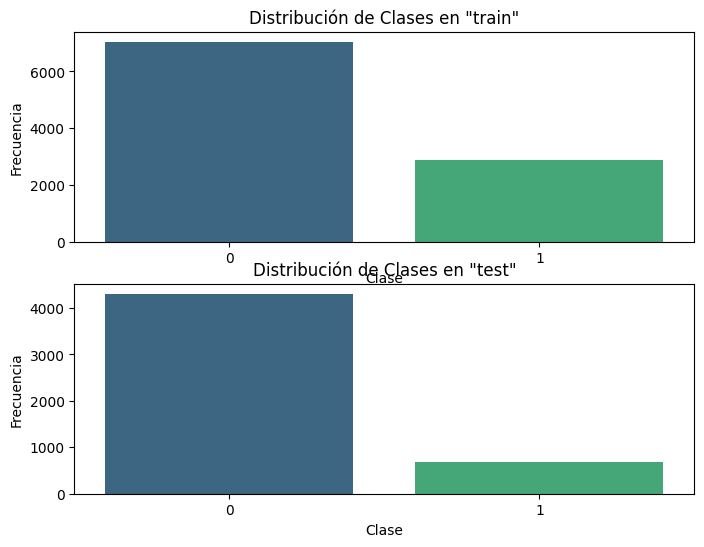

In [36]:
matplotlib.pyplot.figure(figsize=(8, 6))

matplotlib.pyplot.subplot(2, 1, 1)
seaborn.countplot(x='label', data=df_train_corrected, palette='viridis')
matplotlib.pyplot.title('Distribución de Clases en "train"')
matplotlib.pyplot.xlabel('Clase')
matplotlib.pyplot.ylabel('Frecuencia')

matplotlib.pyplot.subplot(2, 1, 2)
seaborn.countplot(x='label', data=df_test, palette='viridis')
matplotlib.pyplot.title('Distribución de Clases en "test"')
matplotlib.pyplot.xlabel('Clase')
matplotlib.pyplot.ylabel('Frecuencia')

matplotlib.pyplot.show()

Veamos rápidamente si hay alguna diferencia entre las dos clases con respecto al origen del texto.

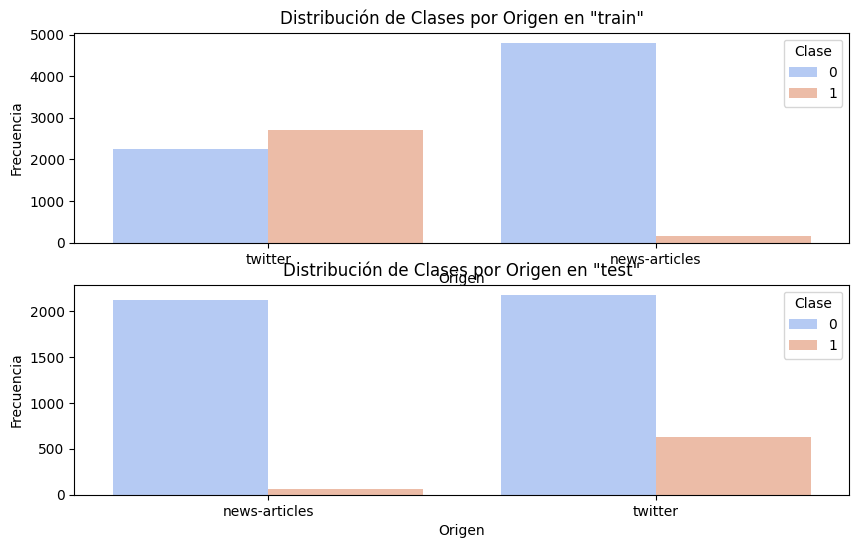

In [37]:
matplotlib.pyplot.figure(figsize=(10, 6))

matplotlib.pyplot.subplot(2, 1, 1)
seaborn.countplot(
    x='origin',
    hue='label',
    data=df_train_corrected, palette='coolwarm'
    )
matplotlib.pyplot.title('Distribución de Clases por Origen en "train"')
matplotlib.pyplot.xlabel('Origen')
matplotlib.pyplot.ylabel('Frecuencia')
matplotlib.pyplot.legend(title='Clase')

matplotlib.pyplot.subplot(2, 1, 2)
seaborn.countplot(
    x='origin',
    hue='label',
    data=df_test, palette='coolwarm'
    )
matplotlib.pyplot.title('Distribución de Clases por Origen en "test"')
matplotlib.pyplot.xlabel('Origen')
matplotlib.pyplot.ylabel('Frecuencia')
matplotlib.pyplot.legend(title='Clase')

matplotlib.pyplot.show()

Por lo que vemos en la última gráfica, tanto en el dataset de entrenamiento como en el de evaluación, la mayoría de los ejemplos de lenguaje tóxico provienen de Twitter, a pesar de que el origen de los textos sí está equilibrado en los datasets. Esto no tendrá ninguna repercusión en nuestro modelo.

**Oversampling & Undersampling:**

Una manera de solventar este desajuste en la distribución de clases sería la técnica de *oversampling/undersampling*. Esta técnica se basa en la generación de ejemplos sintéticos de la clase minoritaria y en la eliminación aleatoria de ejemplos de la clase mayoritaria, de forma que se iguale la proporción de clases.

Por un lado, no disponemos de una gran cantidad de datos, por lo que el *undersampling*, es decir, eliminar ejemplos del dataset para equilibrar las clases (lo que requeriría una gran cantidad de datos borrados) podría ser perjudicial para el desempeño del modelo.

Por otro lado, la generación de sintética de datos de la clase minoritaría (*oversampling*) puede llevar a la introducción de un sesgo, pues esta técnica implica replicar instancias de la clase minoritaria para aumentar su representación. Esta introducción de ejemplos redundantes puede llevar a una situación de *overfitting* del modelo.

Además, una de las restricciones que tenemos en esta prueba es no modificar el dataset "test", por lo que incluso si utilizáramos la técnica de *oversampling/undersampling* evitando sus riesgos, aún tendríamos un desajuste de clases enorme en el conjunto de datos de prueba.

**Ponderación de clases durante el entrenamiento:**

Otra manera de intentar evitar que este desajuste afecte al entrenamiento del modelo, es ponderar las clases en base a su ratio de desajuste. Esto ayudaría al modelo a prestar más atención a los ejemplos de la clase menos frecuente y a mitigar el impacto del desbalanceo.

Aunque esta ténica (como cualquier otra) no es una solución perfecta, es posiblemente la mejor opción para cumplir con los objetivos de la prueba, dadas sus restricciones.

### 1.3 Longitud de los textos:

Analizar la longitud de los textos en el contexto del fine-tuning de un modelo para la clasificación de los mismos puede ser útil por varias razones, por ejemplo:
- conocer la distribución de la longitud de los textos nos permitirá determinar una longitud máxima adecuada para el modelo
- podríamos decidir excluir textos extremadamente cortos o largos durante el preprocesamiento

En el contexto de esta prueba, entenderemos "longitud del texto" como número de tokens en el texto pre-procesado.

In [38]:
# add length columns containing the number of tokens in the text
df_train_corrected['text_length_es'] = df_train_corrected[
    'text_processed_es'
    ].apply(lambda x: len(x.split()))
df_train_corrected['text_length_en'] = df_train_corrected[
    'text_processed_en'
    ].apply(lambda x: len(x.split()))
df_train_corrected['text_length_fr'] = df_train_corrected[
    'text_processed_fr'
    ].apply(lambda x: len(x.split()))

Comenzamos viendo las longitudes comparadas entre idiomas:

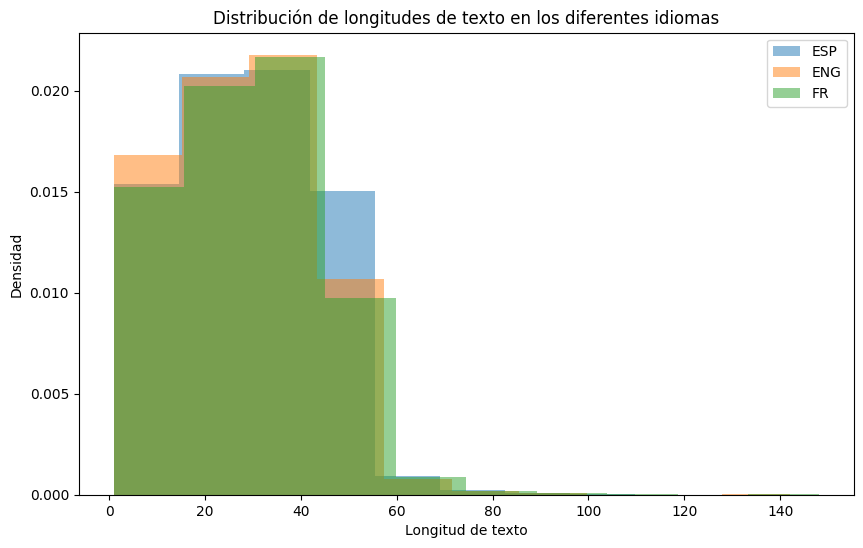

In [39]:
matplotlib.pyplot.figure(figsize=(10, 6))
matplotlib.pyplot.hist(
    df_train_corrected['text_length_es'],
    bins=10,
    alpha=0.5,
    label='ESP',
    density=True
    )
matplotlib.pyplot.hist(
    df_train_corrected['text_length_en'],
    bins=10, alpha=0.5,
    label='ENG',
    density=True
    )
matplotlib.pyplot.hist(
    df_train_corrected['text_length_fr'],
    bins=10,
    alpha=0.5,
    label='FR',
    density=True
    )

matplotlib.pyplot.title('Distribución de longitudes de texto en los diferentes idiomas')
matplotlib.pyplot.xlabel('Longitud de texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

Tenemos un histograma que compara las distribuciones de las longitudes de texto en español, inglés y francés. Cada barra representa un rango de longitudes, y la altura de la barra indica la frecuencia relativa de textos en ese rango de longitudes.

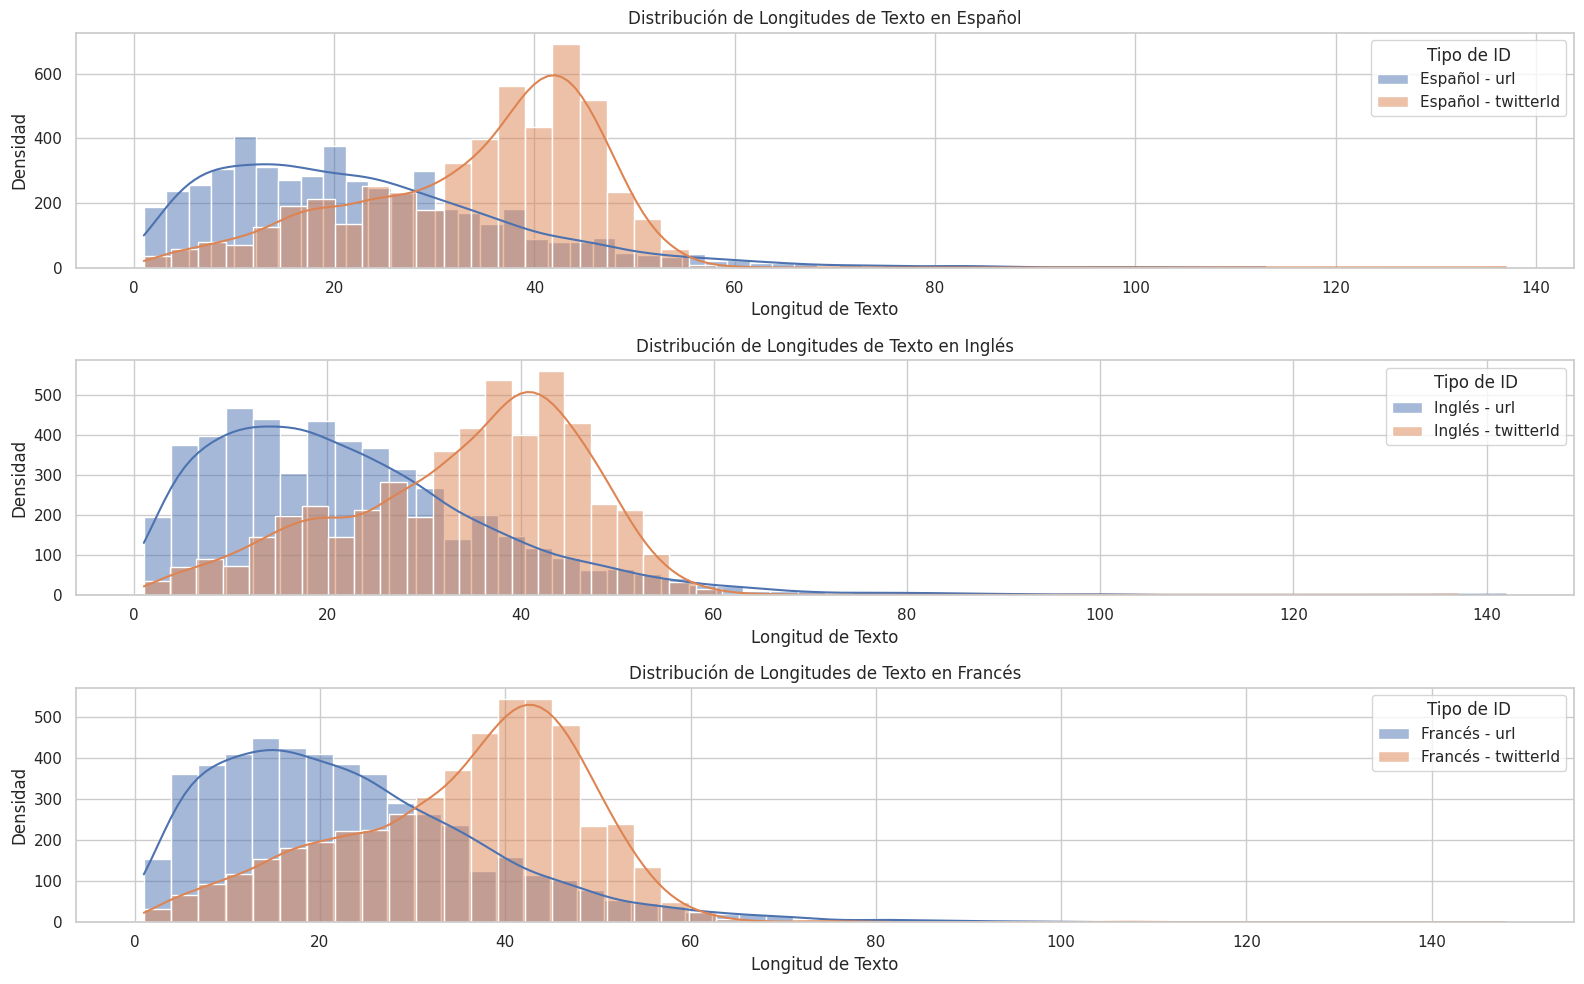

In [40]:
seaborn.set(style="whitegrid")

matplotlib.pyplot.figure(figsize=(16, 10))

matplotlib.pyplot.subplot(3, 1, 1)
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'url'], x='text_length_es', bins=50, alpha=0.5, kde=True, label='Español - url')
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'twitterId'], x='text_length_es', bins=50, alpha=0.5, kde=True, label='Español - twitterId')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Español')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Tipo de ID')

matplotlib.pyplot.subplot(3, 1, 2)
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'url'], x='text_length_en', bins=50, alpha=0.5, kde=True, label='Inglés - url')
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'twitterId'], x='text_length_en', bins=50, alpha=0.5, kde=True, label='Inglés - twitterId')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Inglés')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Tipo de ID')

matplotlib.pyplot.subplot(3, 1, 3)
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'url'], x='text_length_fr', bins=50, alpha=0.5, kde=True, label='Francés - url')
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'twitterId'], x='text_length_fr', bins=50, alpha=0.5, kde=True, label='Francés - twitterId')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Francés')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Tipo de ID')

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

Por lo que podemos ver, los textos que provienen de Twitter tienden a tener una mayor longitud.

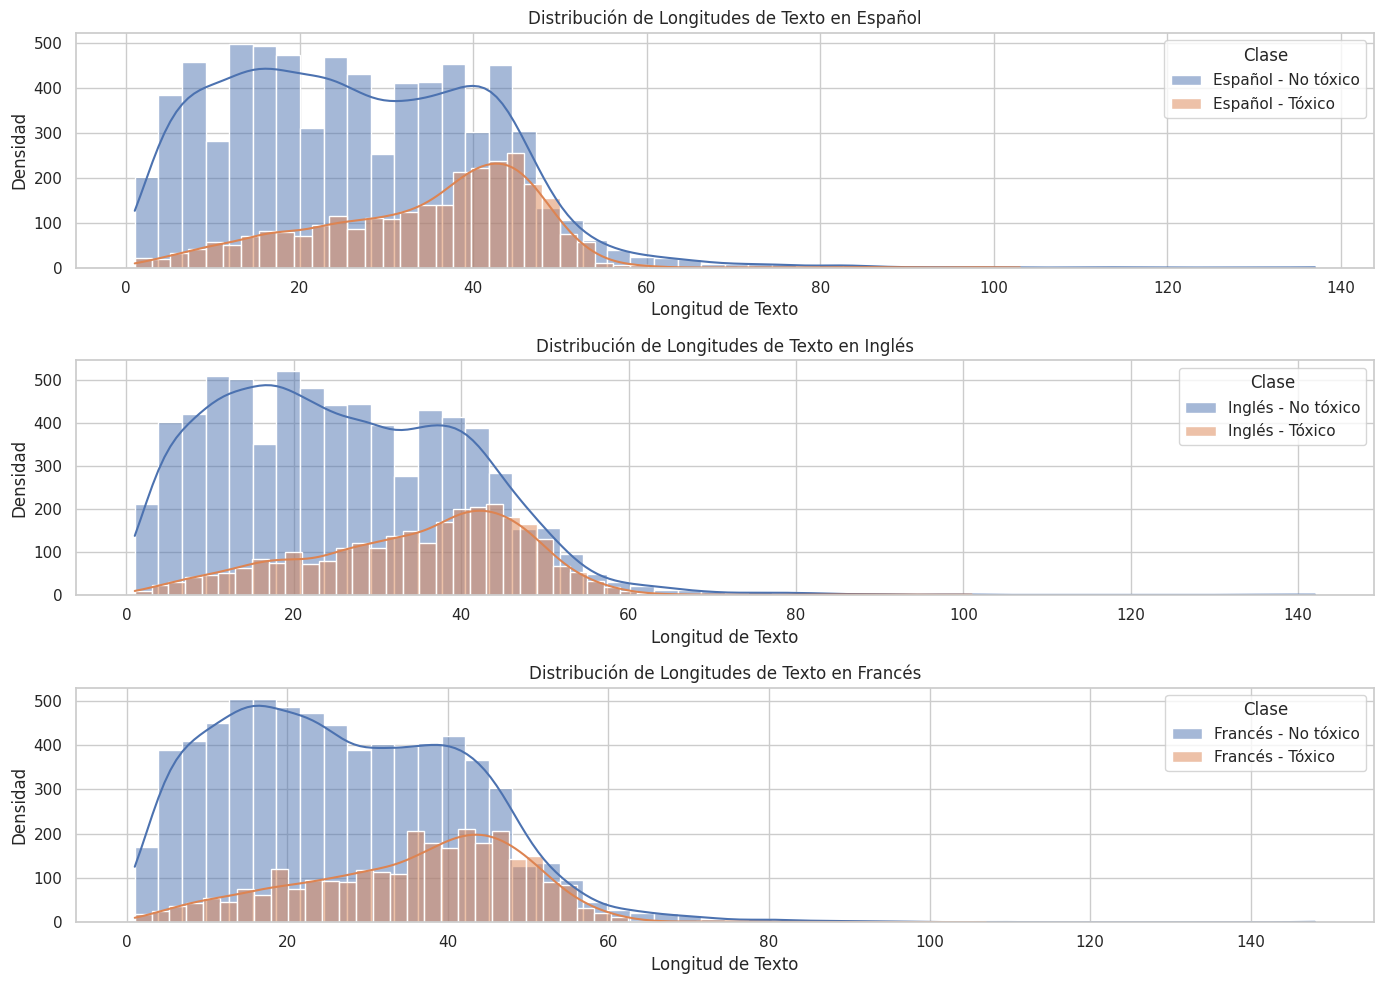

In [41]:
seaborn.set(style="whitegrid")

matplotlib.pyplot.figure(figsize=(14, 10))

matplotlib.pyplot.subplot(3, 1, 1)
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 0], x='text_length_es', bins=50, alpha=0.5, kde=True, label='Español - No tóxico')
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 1], x='text_length_es', bins=50, alpha=0.5, kde=True, label='Español - Tóxico')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Español')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Clase')

matplotlib.pyplot.subplot(3, 1, 2)
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 0], x='text_length_en', bins=50, alpha=0.5, kde=True, label='Inglés - No tóxico')
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 1], x='text_length_en', bins=50, alpha=0.5, kde=True, label='Inglés - Tóxico')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Inglés')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Clase')

matplotlib.pyplot.subplot(3, 1, 3)
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 0], x='text_length_fr', bins=50, alpha=0.5, kde=True, label='Francés - No tóxico')
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 1], x='text_length_fr', bins=50, alpha=0.5, kde=True, label='Francés - Tóxico')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Francés')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Clase')

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

También observamos que los textos de la clase "Tóxico" tienen una tendencia creciente en su longitud hasta alcanzar, aproximadamente, las 50 palabras, a partir de donde su longitud decrece de forma muy similar a los de la clase "No tóxico".

### 1.4 Palabras más comunes:

En esta subsección hacemos un pequeño análisis visual de las palabras más comunes por clase. En concreto, mostraremos las palabras más comunes en cada tipo de lenguaje que no estén entre las más comunes del otro tipo. De esta forma observaremos cuáles son las palabras que más influirán en el modelo a la hora de clasificar el texto. Mostramos estos resultados sólo para el caso del español.

In [42]:
# divide dataframe by classes
df_toxic = df_train_corrected[df_train_corrected['label'] == 1]
df_non_toxic = df_train_corrected[df_train_corrected['label'] == 0]

In [43]:
def get_top_words_no_common(
    text_1: pandas.Series,
    text_2: pandas.Series,
    top_n: int = 20
    ) -> tuple[pandas.Series, pandas.Series]:
    """
    Get most common words of the set differences of two texts.

    The function gets as input two pandas series from where the words are
    obtained. Then, the set differences of the words are computed, that is,
    common words between sets removed. Finally, the top n words of each set not
    present in the other are added to a pandas series, which are returned.

    Args:
        text_1 (pandas.Series): pandas series containing the 1st text
        text_1 (pandas.Series): pandas series containing the 2nd text
        top_n (int): number of words to include in the result

    Returns:
        top_words_df1 (pandas.Series): the resulting top n words in the 1st text
        top_words_df2 (pandas.Series): the resulting top n words in the 2nd text
    """

    words_df1 = ' '.join(text_1).split()
    words_df2 = ' '.join(text_2).split()

    # compute set differences of words from each text
    words_unique_df1 = set(words_df1) - set(words_df2)
    words_unique_df2 = set(words_df2) - set(words_df1)

    # get top_n most common words of each set and not included in the other set
    top_words_df1 = (
        pandas.Series(words_df1).value_counts().loc[
            lambda x: x.index.isin(words_unique_df1)
            ].head(top_n)
            )
    top_words_df2 = (
        pandas.Series(words_df2).value_counts().loc[
            lambda x: x.index.isin(words_unique_df2)
            ].head(top_n)
            )

    return top_words_df1, top_words_df2

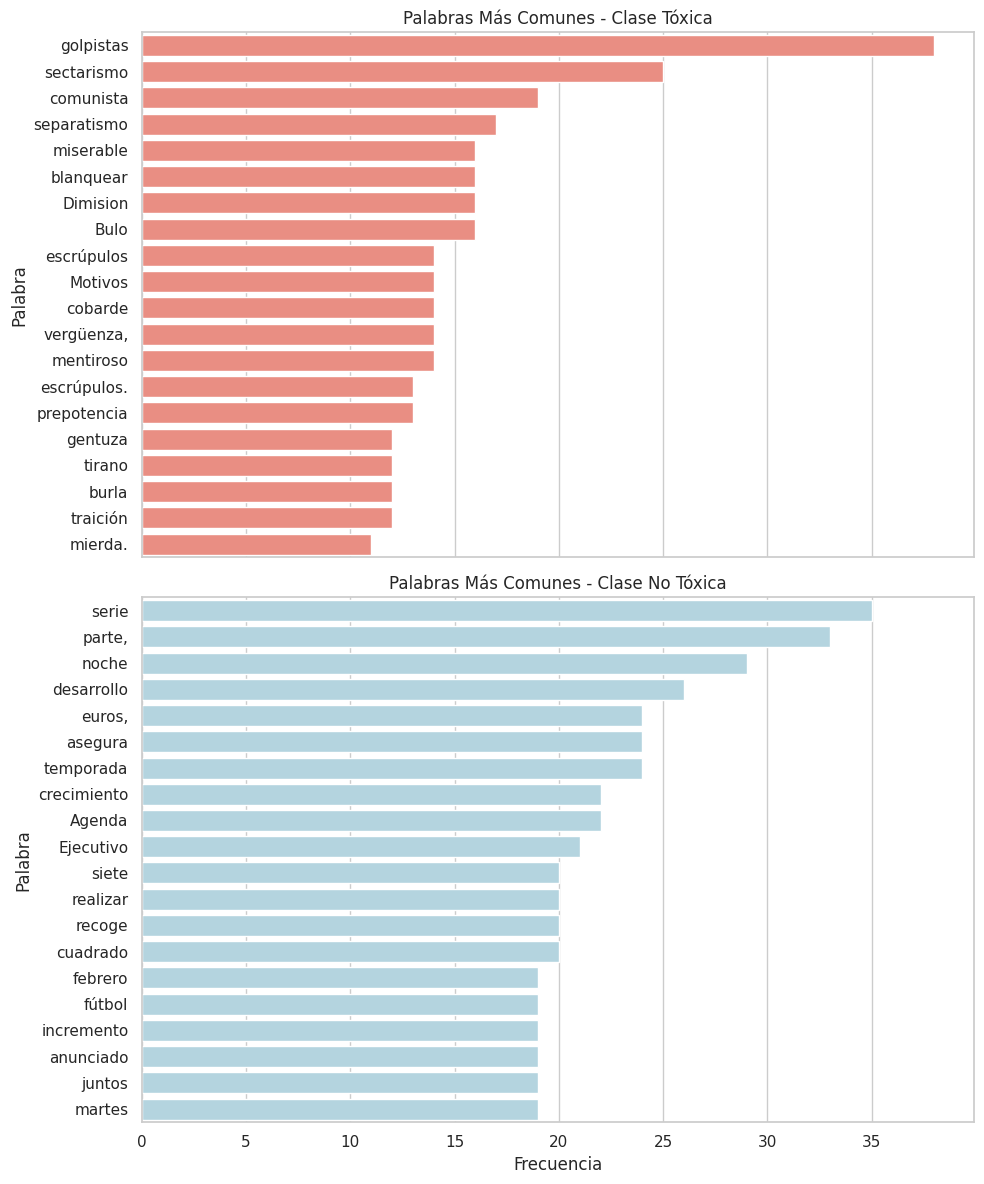

In [44]:
# get most common not shared words of each class (toxic/non toxic)
top_words_toxic, top_words_non_toxic = get_top_words_no_common(
    df_toxic['text_processed_es'],
    df_non_toxic['text_processed_es']
    )

fig, axes = matplotlib.pyplot.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 12),
    sharex=True
    )

seaborn.barplot(
    x=top_words_toxic.values,
    y=top_words_toxic.index,
    ax=axes[0],
    color='salmon'
    )
axes[0].set_title('Palabras Más Comunes - Clase Tóxica')
axes[0].set_xlabel('Frecuencia')
axes[0].set_ylabel('Palabra')

seaborn.barplot(
    x=top_words_non_toxic.values,
    y=top_words_non_toxic.index,
    ax=axes[1],
    color='lightblue'
    )
axes[1].set_title('Palabras Más Comunes - Clase No Tóxica')
axes[1].set_xlabel('Frecuencia')
axes[1].set_ylabel('Palabra')

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

Parece bastante razonable la división de palabras encontrada.

# 2. Fine-tuning de modelo pre-entrenado

### 2.1 Entrenamiento del modelo:

Una vez hemos comprendido la estructura de los datos y los hemos pre-procesado de acuerdo a las necesidades que hemos definido, procedemos a la elección de un modelo de lenguage pre-entrenado para su fine-tuning con nuestros datos.

Para esta tarea, hemos elegido el modelo BERT *cased* en su versión base. Este modelo ha sido pre-entrenado en grandes cantidades de datos multilingües, lo que le permite manejar texto en varios idiomas con buen rendimiento, por lo que debería de ser un buen candidato para nuestra tarea de clasificación.

A continuación, ponderamos los pesos de las clases tóxico/no tóxico para mitigar el desajuste de balance entre una y otra (esta fue la solución propuesta en el primer apartado cuando se observó este problema), dividimos los datos en entrenamiento y validación, y definimos el tokenizador del modelo.

In [45]:
# compute weights classes to balance during training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=numpy.unique(df_train_corrected['label']),
    y=numpy.array(df_train_corrected['label'])
    )
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [46]:
# divide data into train and validation
train, validation = train_test_split(
    df_train_corrected,
    test_size=0.2,
    random_state=42
    )
train.reset_index(inplace=True)
validation.reset_index(inplace=True)

In [47]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Ahora definimos una clase de tipo `Dataset` que nos permita cargar y acceder a los datos para entrenar un modelo de PyTorch.

In [48]:
class ToxicityDataset(Dataset):
    """Instance of a toxicity dataset."""

    def __init__(self, texts, labels, max_length=162):
        """Initialise the toxicity dataset."""
        self.texts = texts
        self.labels = labels
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        """Return length of dataset."""
        return len(self.labels)

    def __getitem__(self, idx):
        """Return data into model form."""
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx])

        # tokenize texts
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': label
        }

Los objetos de tipo `Dataset` son comúnmente utilizados junto con los `DataLoader` de PyTorch. Los `DataLoader` proporcionan una forma conveniente de cargar los datos en lotes y paralelizar la carga de datos, lo que puede mejorar significativamente la eficiencia durante el entrenamiento.

A continuación, escribimos una función donde preparamos los datos para su uso por el modelo. La función realiza las siguientes tareas:


*   crear una lista de textos (alternando español, inglés y francés), con sus etiquetas asociadas; esto se hará para los datos de entrenamiento y la validación. Para los datos de evaluación se concatenarán los textos de los diferentes idiomas, y las etiquetas asociadas se pasarán por triplicado (dado que son compartidas para los tres idiomas).
*   utilizar la clase de tipo `Dataset` y un `DataLoader` para crear los datos de entramiento en el formato que requiere el modelo.

In [49]:
def create_data_loader(
    df: pandas.DataFrame,
    columns: list,
    alternate_languages: bool=True,
    shuffle: bool=True
    ) -> DataLoader:
    """
    Uses the data to create a DataLoader for model consumption.

    Args:
      df (pandas.DataFrame): dataframe containing text and label data
      columns (list): list of dataframe columns names containing the text
      alternate_languages (bool): bool indicating whether or not to alternate
      the different languages
      shuffle (bool): bool indicating whether or not to shuffle the DataLoader

    Return:
      DataLoader: data loader for model consumption
    """
    list_of_texts = []
    list_of_labels = df['label'].tolist()

    if alternate_languages:
      # used for training and validation, not for evaluation
      num_rows = len(df)

      # create a cyclic iterator for the columns
      column_iterator = cycle(columns)

      # get only the text from one lang for each row, and alternate languages
      for i in range(num_rows):
        column = next(column_iterator)
        text_value = str(df.loc[i, column])
        list_of_texts.append(text_value)
    else:
      # concat Spanish, English and French texts
      list_of_texts = (
          df[columns[0]].tolist() +
          df[columns[1]].tolist() +
          df[columns[2]].tolist()
      )

      # repeat the labels 3 times (same labels for each language)
      list_of_labels = df['label'].tolist() * 3

    # create dataset
    dataset = ToxicityDataset(list_of_texts, list_of_labels)

    return DataLoader(dataset, batch_size=32, shuffle=shuffle)

En las tres siguientes celdas tenemos las funciones para el entrenamiento y la validación de una época de entrenamiento para nuestro modelo de clasificación, así como la función que utilizaremos para su evaluación.

La función `train_epoch` realiza el bucle de entrenamiento sobre los datos de entrenamiento, actualiza los parámetros del modelo para minimizar la pérdida y calcula las métricas de rendimiento, en este caso, la precisión y la pérdida promedio, para esa época específica.

Por su parte, la función `validate_epoch` realiza una evaluación del modelo sobre los datos de validación, calcula la precisión y la pérdida promedio y retorna estos valores para su análisis.

La función `evaluate_model` realiza una evaluación del modelo sobre los datos de testing y devuelve las predicciones hechas por el modelo así como los valores reales de las etiquetas.

In [50]:
def train_epoch(
    model: torch.nn.Module,
    criterion: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader,
    optimizer: torch.optim,
    device: str,
    n_examples: int
) -> tuple[torch.Tensor, numpy.float64]:
    """
    Runs one epoch of training for the model.

    Args:
      model (torch.nn.Module): model to be trained
      criterion (torch.nn.CrossEntropyLoss): loss function for class
      weights ponderation
      dataloader (DataLoader): dataloader for model consumption
      optimizer (torch.optim): model optimizer
      device (str): string indicating what device to be used
      n_examples (int): length of training dataset

    Return:
      tuple[torch.Tensor, numpy.float64]: train accuracy and loss of epoch
    """
    model.train()

    losses = []
    correct_predictions = 0

    # iterate over batches of the dataloader
    for batch in tqdm(dataloader, desc=f'Training'):
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['label'].to(device)
        }
        # compute the outputs of the model using the input data
        outputs = model(**inputs)

        # compute the loss comparing the outputs of the model and the labels
        # using the CrossEntropyLoss loss function
        loss = criterion(outputs.logits, inputs['labels'])
        losses.append(loss.cpu().item())

        # track the number of correct predictions
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(
            predictions == batch['label'].to(device)
            )

        # back-propagate, optimize model parameters and re-start gradients
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return (
        correct_predictions.cpu().double() / n_examples,
        sum(losses) / len(losses)
        )

In [51]:
def validate_epoch(
    model: torch.nn.Module,
    criterion: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader,
    device: str,
    n_examples: int
) -> tuple[torch.Tensor, numpy.float64]:
    """
    Runs one epoch of validation for the model.

    Args:
      model (torch.nn.Module): model for validation
      criterion (torch.nn.CrossEntropyLoss): loss function for class
      weights ponderation
      dataloader (DataLoader): dataloader for model consumption
      device (str): string indicating what device to be used
      n_examples (int): length of validation dataset

    Return:
      tuple[torch.Tensor, numpy.float64]: validation accuracy and loss of epoch
    """
    model.eval()

    losses = []
    correct_predictions = 0

    # avoid gradients computation during validation (not to update parameters)
    with torch.no_grad():
        # iterate over batches of the dataloader
        for batch in tqdm(dataloader, desc=f'Validación'):
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['label'].to(device)
            }
            # compute the outputs of the model using the input data
            outputs = model(**inputs)

            # compute the loss comparing the outputs of the model and the labels
            # using the CrossEntropyLoss loss function
            loss = criterion(outputs.logits, inputs['labels'])
            losses.append(loss.cpu().item())

            # track the number of correct predictions
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(
                predictions == batch['label'].to(device)
                )

    return (
        correct_predictions.cpu().double() / n_examples,
        sum(losses) / len(losses)
        )

In [52]:
def evaluate_model(
    model: torch.nn.Module,
    dataloader: DataLoader,
    device: str
) -> tuple[list, list]:
    """
    Evaluate the model on given data and return predictions and true labels.

    Args:
      model (torch.nn.Module): model for validation
      dataloader (DataLoader): dataloader for model consumption
      device (str): string indicating what device to be used

    Return:
      tuple[list, list]: list containing true labels and predictions
    """
    model.eval()
    y_true = []
    y_pred = []

    # avoid gradients computation during evaluation
    with torch.no_grad():
        # iterate over batches of the dataloader
        for batch in tqdm(dataloader, desc=f'Evaluación'):
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['label'].to(device)
            }
            # compute the outputs of the model using the input data
            outputs = model(**inputs)

            # store the predictions and the true labels
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            y_true.extend(batch['label'].tolist())
            y_pred.extend(predictions.tolist())

    return y_true, y_pred

Una vez definidas las clases y funciones necesarias para el formato de datos, el entrenamiento, la validación y la evaluación del modelo, comenzamos a invocar a cada una de ellas para iniciar el fine-tuning del modelo.

In [53]:
# create dataloaders for all data
train_dataloader = create_data_loader(
    train,
    ['text_processed_es', 'text_processed_en', 'text_processed_fr']
    )
validation_dataloader = create_data_loader(
    validation,
    ['text_processed_es', 'text_processed_en', 'text_processed_fr'],
    shuffle=False
    )
test_dataloader = create_data_loader(
    df_test,
    ['text', 'english', 'french'],
    alternate_languages=False,
    shuffle=False
    )

Al modelo pre-entrenado se le ha añadido una última capa secuencial que consta de dos capas lineales y una última de tipo ReLU. Se espera que con estas capas mejore ligeramente el desempeño del modelo.

Para el entrenamiento se ha elegido un optimizador de tipo AdamW. Este optimizador es una variante del optimizador Adam que corrige un problema de sesgo en la actualización de pesos. La adición de términos de peso de decaimiento es beneficioso para el entrenamiento, ya que ayuda a prevenir un sobreajuste excesivo y mejora la generalización del modelo.

La tasa de aprendizaje (learning rate) es un hiperparámetro que determina el tamaño de los pasos que el optimizador toma durante el entrenamiento. Un valor de 2e-5 es un valor comúnmente utilizado y suele funcionar bien para modelos preentrenados como BERT.

Por otro lado, se utiliza una función de pérdida `CrossEntropyLoss`, una de las más habituales en los problemas de clasificación binaria y multiclase, donde añadimos la correción de pesos de las clases.

La elección de hiper-parámetros se ha realizado siguiendo los siguientes recursos:

* [What are the good parameter ranges for BERT hyperparameters while finetuning it on a very small dataset?](https://datascience.stackexchange.com/questions/64583/what-are-the-good-parameter-ranges-for-bert-hyperparameters-while-finetuning-it)

* [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

In [54]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=2
    ).to(device)
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(768, 384),
    torch.nn.Linear(384, 2),
    torch.nn.ReLU()
    ).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights.to(device),
    reduction='mean'
    )

num_epochs = 4
model_path = 'model/toxicity_model.bin'

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Comenzamos el entrenamiento del modelo utilizando las funciones `train_epoch` y `validate_epoch`.

In [55]:
# training loop
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []
best_accuracy = 0

for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")
  print("-" * 10)

  train_acc, train_loss = train_epoch(
      model,
      criterion,
      train_dataloader,
      optimizer,
      device,
      len(train)
      )
  val_acc, val_loss = validate_epoch(
      model,
      criterion,
      validation_dataloader,
      device,
      len(validation)
      )

  train_accuracies.append(train_acc)
  train_losses.append(train_loss)
  val_accuracies.append(val_acc)
  val_losses.append(val_loss)

  print(
      f'Training Accuracy: {train_acc:.4f}, Training Loss: {train_loss:.4f}'
      )
  print(
      f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}'
      )

  if val_acc > best_accuracy:
        torch.save(model.state_dict(), model_path)
        best_accuracy = val_acc

Epoch 1/4
----------


Validación: 100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


Training Accuracy: 0.8241, Training Loss: 0.3923
Validation Accuracy: 0.8912, Validation Loss: 0.2837
Epoch 2/4
----------


Validación: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


Training Accuracy: 0.9139, Training Loss: 0.2219
Validation Accuracy: 0.9063, Validation Loss: 0.3094
Epoch 3/4
----------


Validación: 100%|██████████| 63/63 [00:22<00:00,  2.77it/s]


Training Accuracy: 0.9472, Training Loss: 0.1308
Validation Accuracy: 0.8907, Validation Loss: 0.3310
Epoch 4/4
----------


Validación: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]

Training Accuracy: 0.9734, Training Loss: 0.0725
Validation Accuracy: 0.8987, Validation Loss: 0.3973


Mostramos en una gráfica las métricas de precisión y pérdida recogidas durante el entrenamiento.

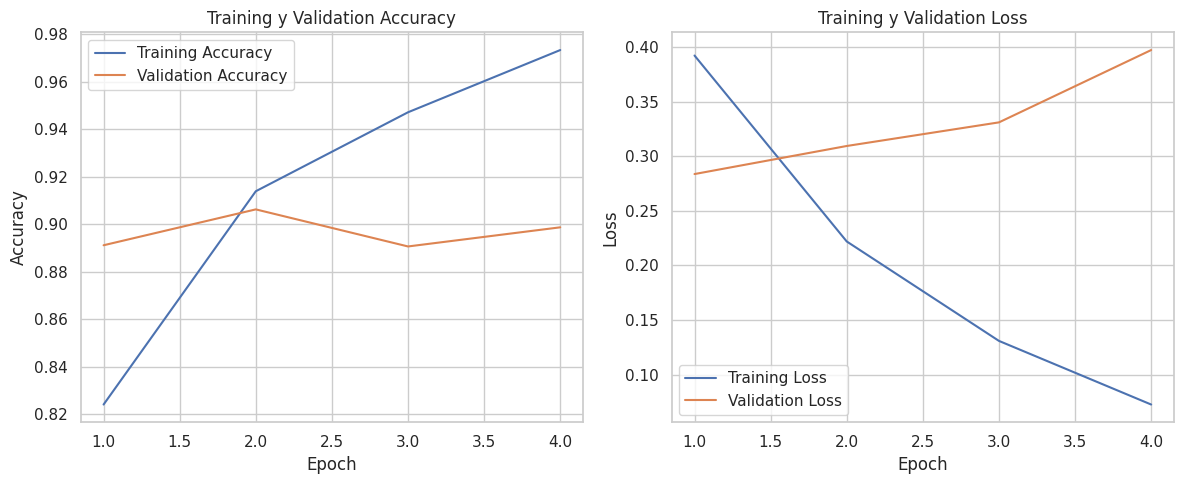

In [56]:
epochs = list(range(1, num_epochs + 1))

matplotlib.pyplot.figure(figsize=(12, 5))

matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.plot(epochs, train_accuracies, label='Training Accuracy')
matplotlib.pyplot.plot(epochs, val_accuracies, label='Validation Accuracy')
matplotlib.pyplot.title('Training y Validation Accuracy')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.legend()

matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.plot(epochs, train_losses, label='Training Loss')
matplotlib.pyplot.plot(epochs, val_losses, label='Validation Loss')
matplotlib.pyplot.title('Training y Validation Loss')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Loss')
matplotlib.pyplot.legend()

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

Observamos lo siguiente:
1. **Precisión del Modelo:**
   - La precisión del modelo durante el entrenamiento es alta, superando el 97% en la última época.
   - La precisión en la validación también es buena, alcanzando alrededor del 89% en la última época.

2. **Pérdida del Modelo:**
   - La pérdida durante el entrenamiento disminuye consistentemente, indicando una mejora en la capacidad del modelo para ajustarse a los datos de entrenamiento.
   - Sin embargo, la pérdida en la validación aumenta en las últimas épocas, lo cual puede indicar cierto sobreajuste del modelo a los datos de entrenamiento.

### 2.2 Evaluación del modelo entrenado:

Por último, evaluamos el modelo sobre los datos de evaluación y sacamos las conclusiones necesarias.

In [57]:
# get true labels and predictions from test data
true_labels, predictions = evaluate_model(model, test_dataloader, device)

Evaluación: 100%|██████████| 469/469 [02:49<00:00,  2.77it/s]


Hemos elegido las métricas más habituales para evaluar modelos de clasificación como este: accuracy, precision, recall, f1-score y support. Se muestra además la matriz de confusión.


*   accuracy: mide la proporción de predicciones correctas sobre el total de predicciones
*   precision: TP/(TP + FP), es decir, mide la calidad de las predicciones positivas
*   recall: TP/(TP + FN), es decir, mide la capacidad del modelo para capturar todas las instancias positivas
*   f1-score: combina precision y recall en una sola métrica (media armónica), útil cuando hay un desbalance entre las clases
*   soporte: número total de instancias en una clase
*   matriz de confusión: muestra el número de predicciones correctas e incorrectas clasificadas en cada clase



In [58]:
# evaluate model with metrics
print("\nTest Accuracy:", accuracy_score(true_labels, predictions))
print("\nClassification Report:")
print(classification_report(true_labels, predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))


Test Accuracy: 0.8545333333333334

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     12924
           1       0.48      0.71      0.57      2076

    accuracy                           0.85     15000
   macro avg       0.72      0.79      0.74     15000
weighted avg       0.88      0.85      0.87     15000


Confusion Matrix:
[[11353  1571]
 [  611  1465]]


Por último, representamos la curva "Receiver Operating Characteristic" (ROC) y calculamos su área por debajo de la curva (AUC).

La curva ROC es útil para visualizar cómo varía el rendimiento del clasificador. Un AUC más alto indica un mejor rendimiento del modelo en términos de discriminación entre clases. La línea punteada representa el rendimiento de un clasificador aleatorio, y el objetivo es que la curva ROC del modelo esté por encima de esta línea.

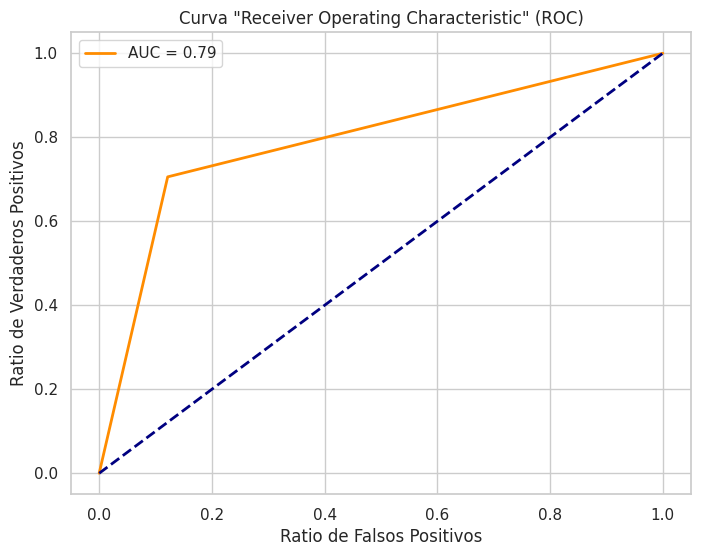

In [59]:
# compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# plot ROC curve and AUC value
matplotlib.pyplot.figure(figsize=(8, 6))
matplotlib.pyplot.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
matplotlib.pyplot.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
matplotlib.pyplot.xlabel('Ratio de Falsos Positivos')
matplotlib.pyplot.ylabel('Ratio de Verdaderos Positivos')
matplotlib.pyplot.title('Curva "Receiver Operating Characteristic" (ROC)')
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

Sacamos las siguientes conclusiones de los resultados de la evaluación del modelo:

1. **Precisión del Modelo:**
   - La precisión en los datos de prueba es del 85%, lo cual es razonable.

2. **Informe de Clasificación:**
   - La clase 0 tiene una precisión del 95%, lo que significa que el modelo clasifica correctamente alrededor del 95% de las instancias que predice como clase 0.
   - La clase 1 tiene una precisión más baja del 48%, lo que indica que el modelo tiene más dificultades para clasificar correctamente las instancias de la clase 1.

3. **Matriz de Confusión:**
   - La matriz de confusión muestra que el modelo tiende a clasificar incorrectamente algunas instancias de la clase 1 como clase 0 (1571 falsos positivos).
   - También hay un número considerable de verdaderos positivos (1465), pero también hay algunos falsos negativos (611), lo que indica que el modelo no logra capturar todas las instancias de la clase 1.

4. **AUC (Área bajo la Curva ROC):**
   - El AUC es 0.79, lo cual indica un rendimiento moderadamente bueno para la clasificación binaria. Un AUC de 0.5 sería equivalente a una clasificación aleatoria, mientras que un AUC de 1.0 sería una clasificación perfecta.

Conclusiones generales del desempeño del modelo:

- El modelo parece ser bastante bueno para la clase 0, pero tiene dificultades con la clase 1.
- Podría ser beneficioso ajustar el modelo para mejorar el rendimiento en la clase 1, quizás mediante técnicas de ajuste de hiperparámetros, ajuste del umbral de decisión, o considerando otras arquitecturas de modelos.
- Además, es importante monitorear el sobreajuste, ya que la pérdida en la validación aumenta después de cierto punto. Podrían explorarse técnicas como la regularización para abordar esto.

### 2.3 Valoración del uso de un LLM para esta tarea:

Para la tarea planteada, incluso teniendo acceso a un LLM, probablemente no tiene sentido utilizarlo salvo algunos concretos.

En principio, con más tiempo para un tratamiento más intensivo de los datos y una mejor exploración de los hiperparámetros del modelo (así como otras experimentaciones que se podrían llevar a cabo), deberíamos ser capaces de conseguir un clasificador robusto con un ajuste de modelo como el planteado en la tarea.

Sin embargo, habría ciertos casos (que no se ajustan a los planteados en esta tarea) donde el uso de un LLM podría tener más sentido:


*   Si no se dispone de datos etiquetados (o la cantidad es muy pequeña), se podría aprovechar el "conocimiento general" del LLM siempre que las clases estén bien definidas y sean comprensibles para el LLM.
*   Si las clases fueses a cambiar habitualmente a lo largo del tiempo.
*   Si necesitásemos una salida algo más elaborada que simplemente la predicción de una clase.

En resumen, no debería de ser necesario el uso de un LLM para conseguir un buen clasificador como el que se ha planteado en la tarea.